# 제4 고지 : 신경망 만들기 
## STEP 43 : 신경망

이전 단계에서는 선형 회귀를 구현했다면, 이번 단계에서는 '신경망'으로 확장해본다.

### 43.1 DeZero의 linear 함수 

<p align='center'>
    <img src='../assets/그림 43-1.png' align='center' width='30%'>
</p>

<span style='background-color : #ffdce0'>💡<b>참고로, $y=Wx+b$ 를 선형변환(linear transformation) 또는 아핀변환(affine transformation) 이라 한다. 엄밀히 말하면 $b$가 포함되지 않은 것이 선형변환이지만, 일반적으로 $b$를 포함하여 선형변환이라고 부른다. 그리고 이는 fully connected layer에 해당하며, 매개변수 $W$는 weight, $b$는 bias라고 한다.</b></span>  

선형회귀 계산 $y=Wx+b$는 두가지 방식으로 구현가능하다.

1. 앞서살펴본 DeZero함수를 사용하는 것
2. `Function` 을 상속하여 새롭게 `Linear` 함수를 구현하는 것

앞서 42.4 에서 살펴봤듯이, 메모리를 더 효율적으로 사용하기 위해 2번 방식으로 구현한다.

```python
class Linear(Function):
    def forward(self, x, W, b):
        y = x.dot(W) # matmul 
        if b is not None:
            y += b
        return y

    def backward(self, gy):
        x, W, b = self.inputs
        gb = None if b.data is None else sum_to(gy, b.shape)
        gx = matmul(gy, W.T)
        gW = matmul(x.T, gy)
        return gx, gW, gb


def linear(x, W, b=None):
    return Linear()(x, W, b)
```

### 43.2 비선형 데이터셋

<p align='center'>
    <img src='../assets/그림 43-2.png' align='center' width='30%'>
</p>

```python
import numpy as np

np.random.seed(0)
x = np.random.rand(100,1)
y = np.sin(2 *np.pi *x) + np.random.rand(100,1) #  데이터 생성에 sin 함수 이용

```
이전 단계에서는 선형 관계에 있는 토이 데이터셋을 활용했다면, 이번 단계에서는 비선형 데이터셋을 활용해본다.

### 43.3 활성화 함수와 신경망

<p align='center'>
    <img src='../assets/그림 43-3.png' align='center' width='30%'>
</p>

$$
y= \frac{1}{1+e^{-x}}
\Rightarrow tanh(x)=\frac{e^x-e^{-x}}{e^x+e^{-x}}= 2 * \text{sigmoid}(2x)-1
$$

선형 변환은 이름 그래도 입력데이터를 션형으로 변환해준다. 한편 신경망은 선형변환의 출력에 **비선형변환**을 하는 **활성화함수(activation function)** 를 거치게 된다. (만약 선형변환으로만 이뤄진다면 신경망을 깊게 쌓는것이 의미가 없다.)  
대표적으로 `ReLU`, `sigmoid` 함수 등이 있는데, 여기에서는 활성화 함수로 시그모이드 함수를 사용한다. 

여기서도 역시 메모리 효율성을 위해 `Function` 클래스를 상속받아 구현한다.
$$

$$
```python
class Sigmoid(Function):
    def forward(self, x):
        # y = 1 / (1 + xp.exp(-x))
        y = np.tanh(x * 0.5) * 0.5 + 0.5  # Better implementation
        return y

    def backward(self, gy):
        y = self.outputs[0]()
        gx = gy * y * (1 - y)
        return gx


def sigmoid(x):
    return Sigmoid()(x)
```

### 43.4 신경망 구현
일반적으로 신경망은 **'선형변환 -> 활성화 함수 -> 선형변환 -> 활성화 함수 -> ...'** 의 형태로 연속적으로 변환을 수행한다. 다음 예제는 2층 신경망을 바탕으로 학습을 구현한다.  

(<span style='background-color : #ffdce0'>💡<b>신경망에서의 가중치 초깃값은 무작위로 설정한다. 만약 가중치 값이 서로 비슷하면 곱셈노드의 경우 입력값을 교환하여 역전파에 곱해지는데, 이는 역전파시 갱신되는 가중치 값 역시 비슷해져 학습이 되지 않기 때문이다.</b></span>)

variable(0.8473695850105871)
variable(0.2514286285183606)
variable(0.24759485466749873)
variable(0.23786120447054826)
variable(0.2122223133310295)
variable(0.16742181117834234)
variable(0.09681932619992734)
variable(0.07849528290602342)
variable(0.07749729552991154)
variable(0.07722132399559317)


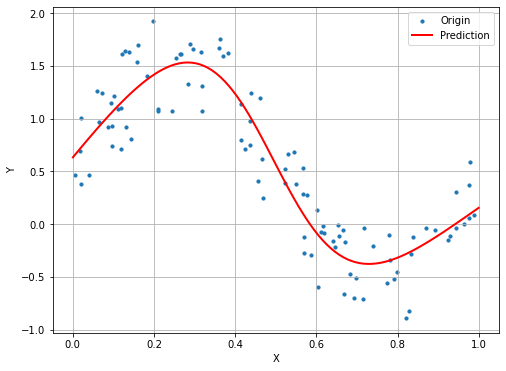

In [3]:
import sys
sys.path.append("..")

import numpy as np 
from dezero import Variable
import dezero.functions as F 

# 토이 데이터셋
np.random.seed(0)
x = np.random.rand(100,1)
y = np.sin(2 *np.pi *x) + np.random.rand(100,1) #  데이터 생성에 sin 함수 이용

W = Variable(np.zeros((1,1)))
b = Variable(np.zeros(1))

# 1. 가중치 초기화 
I,H,O = 1,10,1
W1=Variable(0.01*np.random.randn(I,H)) # 1x10
b1 = Variable(np.zeros(H)) 
W2=Variable(0.01*np.random.randn(H,O)) # 10 x 1 
b2 = Variable(np.zeros(O)) 


# 2. 신경망 추론
def predict(x):
    y= F.linear(x,W1,b1)
    y = F.sigmoid(y)
    y = F.linear(y,W2,b2)
    return y 

# 3. 신경망 학습
lr = 0.2
iters = 10000 
for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y,y_pred)
    
    W1.cleargrad()
    b1.cleargrad()
    W2.cleargrad()
    b2.cleargrad()
    loss.backward()
    W1.data -=lr*W1.grad.data
    b1.data -=lr* b1.grad.data
    W2.data -=lr*W2.grad.data
    b2.data -=lr* b2.grad.data
    
    if i % 1000 == 0:
        print(loss)
        
    
# 위에서 학습한 가중치 W와 편향 b를 사용하여 시각화
import matplotlib.pyplot as plt
x_test = np.linspace(0, 1, 100).reshape(100,1)
# 신경망을 사용하여 예측
y_pred = predict(x_test)

# 그래프로 시각화
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Origin', s=10)
plt.plot(x_test, y_pred.data, label='Prediction', color='red', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()